Import Statements

In [53]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import math 
import seaborn as sns

In [54]:
df=pd.read_csv("/Users/gwenythtan/Desktop/bt4012/PhiUSIIL_Phishing_URL_Dataset.csv")
df.head()
df.dtypes
df.shape
df[df.duplicated] #check duplicated rows 
df.isna().sum() #missing values per feature 
df.isna().sum().sum() #no. of missing cells 

0

Numerical Features

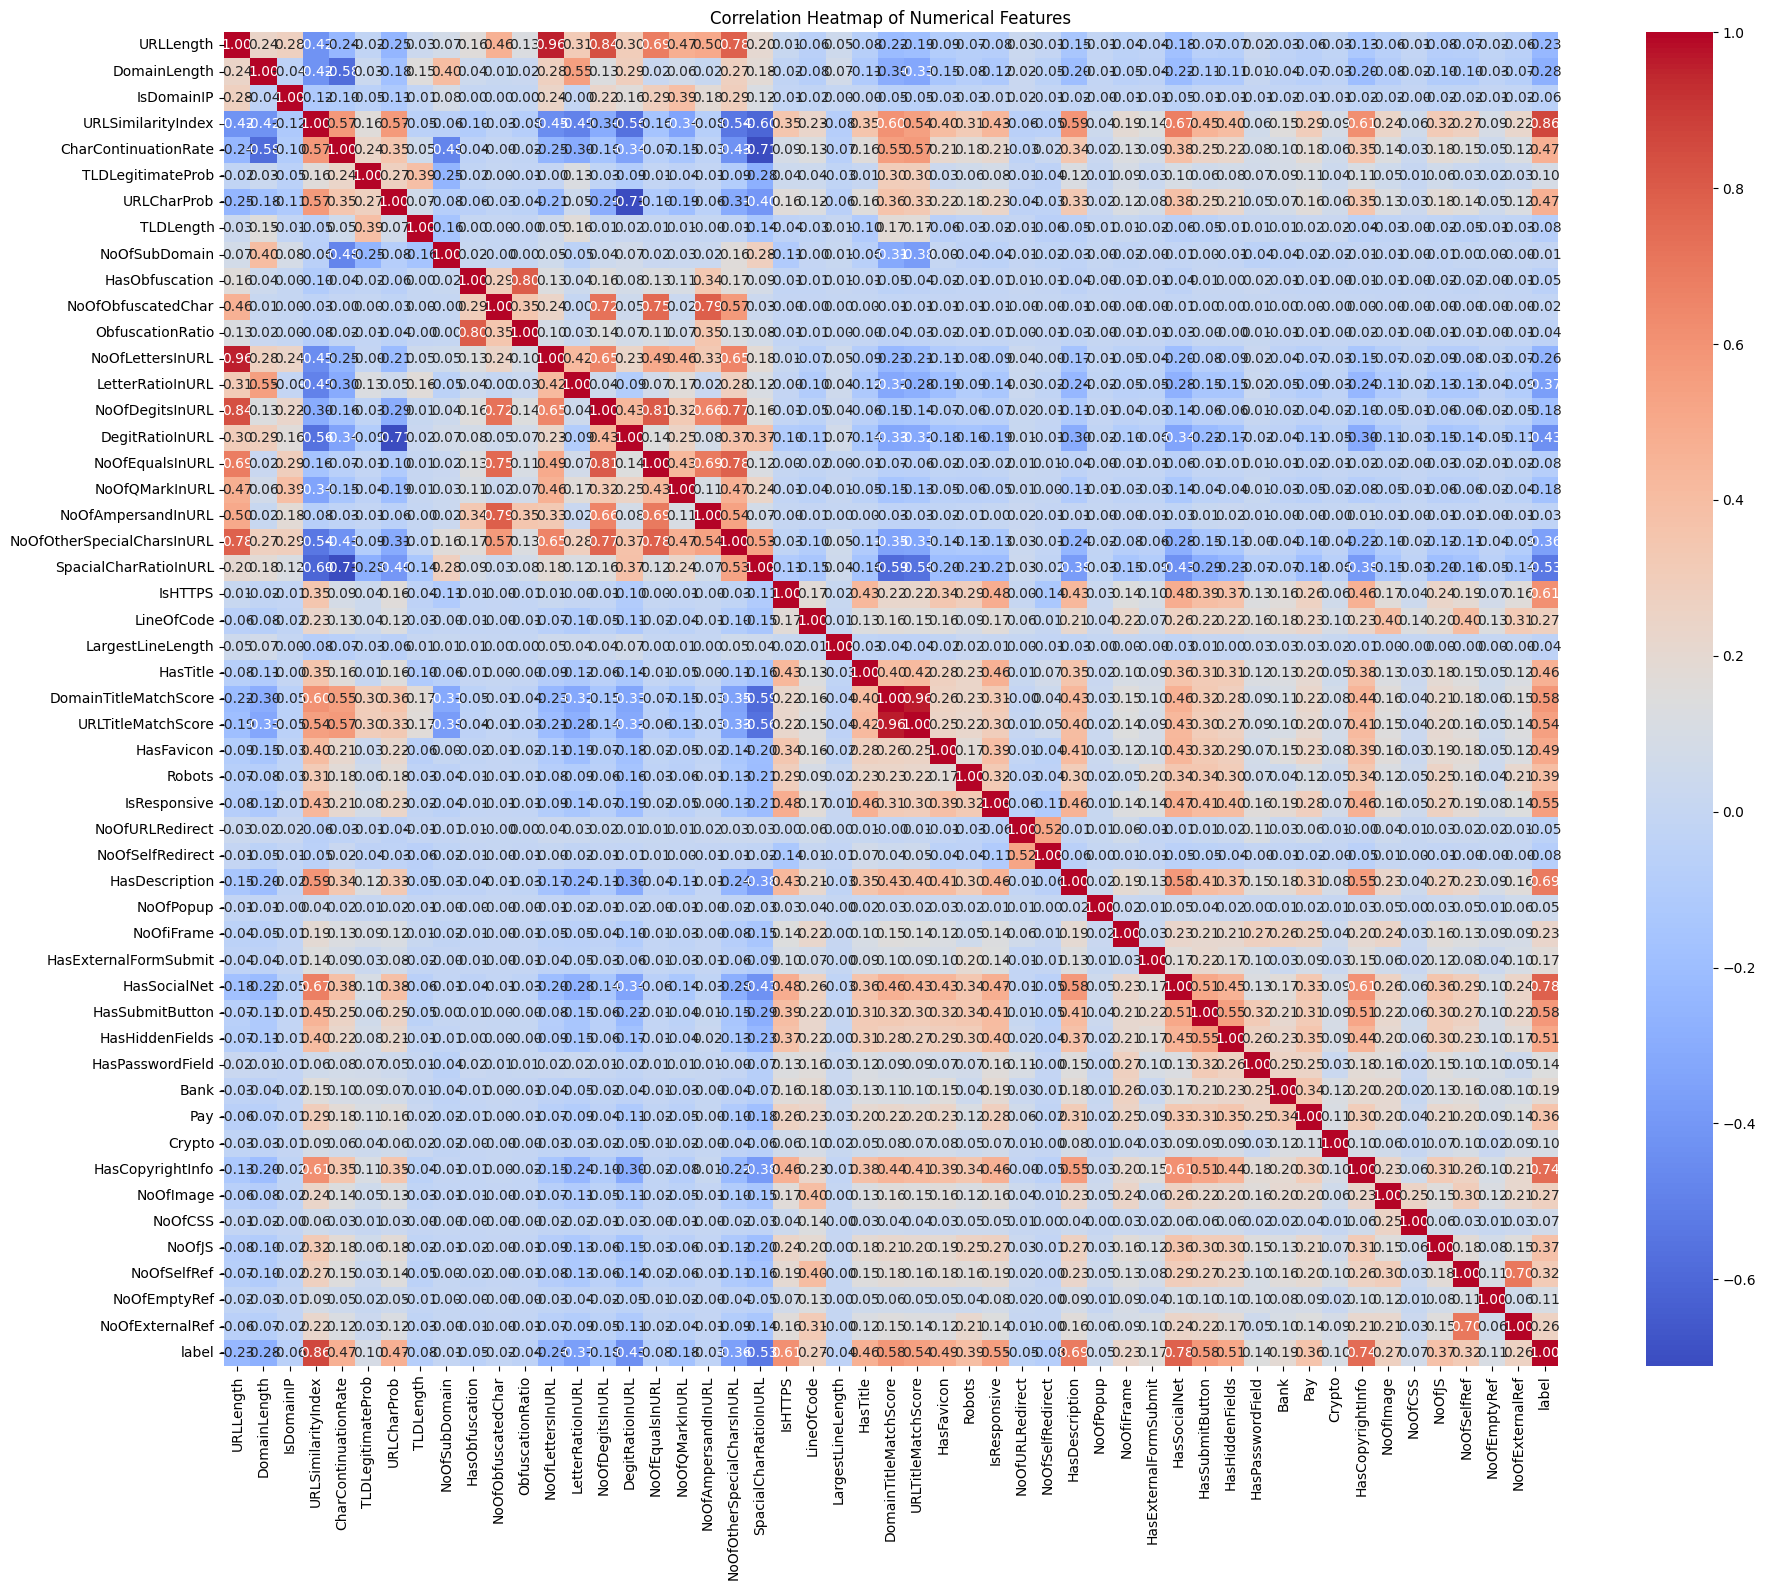

In [55]:
numerical_df = df.select_dtypes(include=['number', 'bool'])
corr_matrix = numerical_df.corr(method='pearson')  # or 'spearman'
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 16))  # adjust size as needed
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()



The correlation heatmap reveals that 
- some features exhibit high multicollinearity such as URLLength and NoOfLetterInURL, suggesting redundancy, can be dropped to simplify model 
- URLSimilarityIndex, HasSocialNet and HasCopyrightInfo show strong postitive correlation with target label, can be prioritised 
- features with correlation near zero to label may be dropped 

Domain-Level Aggregation 
- group dataset by Domain to detect Domain-Level Risk 

,Domain,PhishingRate,URLCount,AvgURLLength,AvgEntropy
43792,www.007b.com,1.0,1,19.0,2.855389
160859,www.paramount.jp,1.0,1,23.0,3.327820
160857,www.paramit.cz,1.0,1,21.0,3.182006
160856,www.parami.org,1.0,1,21.0,3.039149
160855,www.paramedicshop.co.za,1.0,1,30.0,3.642490


,Domain,PhishingRate,URLCount,AvgURLLength,AvgEntropy
22864,ipfs.io,0.0,1197,85.965748,2.521641
15979,docs.google.com,0.0,526,145.526616,2.973557
25843,mail.deliverylifesupport.com,0.0,370,75.194595,3.940760
12668,cloudflare-ipfs.com,0.0,359,94.183844,3.826875
38898,storageapi.fleek.co,0.0,318,93.886792,3.681881


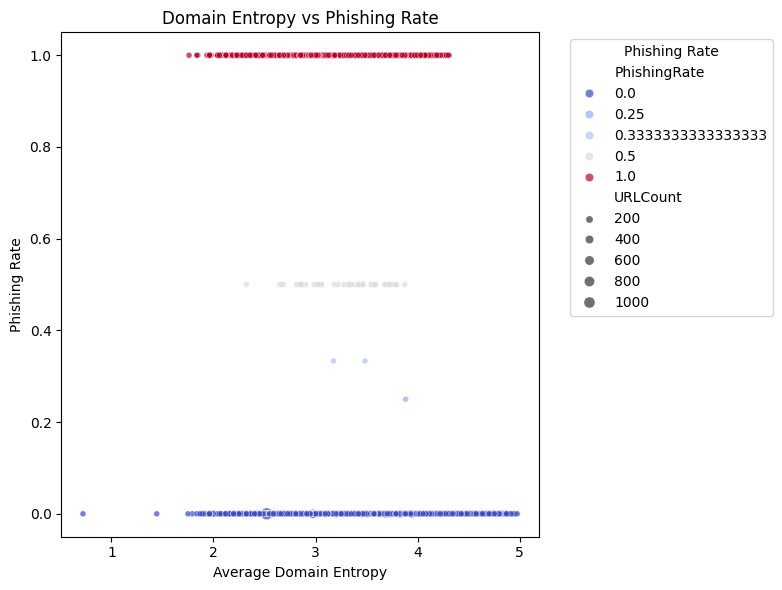

In [56]:
import numpy as np

def calculate_entropy(s):
    if not s:
        return 0
    prob = [s.count(c) / len(s) for c in set(s)]
    return -sum([p * np.log2(p) for p in prob if p > 0])

df['domain_entropy'] = df['Domain'].apply(calculate_entropy)

# Group by Domain to compute domain-level phishing risk
domain_stats = df.groupby('Domain').agg(
    PhishingRate = ('label', 'mean'),
    URLCount = ('label', 'count'),
    AvgURLLength = ('URLLength', 'mean'),
    AvgEntropy = ('domain_entropy', 'mean')
).reset_index()

# View top risky domains (100% phishing rate)
top_phish_domains = domain_stats[domain_stats['PhishingRate'] == 1].sort_values('URLCount', ascending=False)
display(top_phish_domains.head())

# View clean domains (0% phishing rate)
clean_domains = domain_stats[domain_stats['PhishingRate'] == 0].sort_values('URLCount', ascending=False)
display(clean_domains.head())

# Optional: plot phishing rate vs entropy
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(data=domain_stats, x='AvgEntropy', y='PhishingRate', size='URLCount', hue='PhishingRate', palette='coolwarm', alpha=0.7)
plt.title("Domain Entropy vs Phishing Rate")
plt.xlabel("Average Domain Entropy")
plt.ylabel("Phishing Rate")
plt.legend(title="Phishing Rate", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


- domain names that are more random are more likely to be phishing sites 
- moderate to short URL lengths are another common trait of phishing attempts


Error Analysis 
- checking which features are more common in FP/ FN cases
- built a bried RF model to test feature effectiveness and highlight gaps in how phishing sites are identified 

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

# selected optimal features
selected_features = [
    'URLLength',
    'DomainLength',
    'TLDLength',
    'URLSimilarityIndex',
    'URLCharProb',
    'CharContinuationRate',
    'LetterRatioInURL',
    'DegitRatioInURL',
    'NoOfOtherSpecialCharsInURL',
    'URLTitleMatchScore',
    'HasSocialNet',
    'HasCopyrightInfo',
    'HasDescription'
]

# repare input and target
X = df[selected_features]
y = df['label']

# Split train/test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict on test set
y_pred = rf.predict(X_test)

print("🔍 Classification Report:\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

X_test = X_test.copy()  
X_test['label'] = y_test
X_test['pred'] = y_pred

# False Positives (Type I Error)
fp = X_test[(X_test['label'] == 0) & (X_test['pred'] == 1)]
print("\n False Positives (Legit predicted as phishing):", len(fp))
display(fp.head())

# False Negatives (Type II Error)
fn = X_test[(X_test['label'] == 1) & (X_test['pred'] == 0)]
print("\nFalse Negatives (Phishing missed):", len(fn))
display(fn.head())



🔍 Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20189
           1       1.00      1.00      1.00     26970

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159

Confusion Matrix:
 [[20148    41]
 [    3 26967]]

 False Positives (Legit predicted as phishing): 41


,URLLength,DomainLength,TLDLength,URLSimilarityIndex,URLCharProb,CharContinuationRate,LetterRatioInURL,DegitRatioInURL,NoOfOtherSpecialCharsInURL,URLTitleMatchScore,HasSocialNet,HasCopyrightInfo,HasDescription,label,pred
101177,22,16,3,100.0,0.077905,1.000000,0.455,0.0,1,75.0,0,1,1,0,1
154494,25,18,3,100.0,0.062566,1.000000,0.520,0.0,1,100.0,0,0,1,0,1
56879,25,18,3,100.0,0.063592,1.000000,0.480,0.0,1,100.0,0,0,0,0,1
204041,23,17,4,100.0,0.052339,0.625000,0.435,0.0,2,0.0,0,0,0,0,1
112274,32,26,2,100.0,0.063949,0.842105,0.594,0.0,2,0.0,0,0,0,0,1



False Negatives (Phishing missed): 3


,URLLength,DomainLength,TLDLength,URLSimilarityIndex,URLCharProb,CharContinuationRate,LetterRatioInURL,DegitRatioInURL,NoOfOtherSpecialCharsInURL,URLTitleMatchScore,HasSocialNet,HasCopyrightInfo,HasDescription,label,pred
53323,28,21,3,100.0,0.061648,1.0,0.536,0.0,1,100.0,0,0,0,1,0
88694,19,12,2,100.0,0.053075,1.0,0.316,0.0,1,100.0,0,0,0,1,0
190602,37,30,3,100.0,0.060788,1.0,0.649,0.0,1,0.0,0,0,0,1,0


False Positives (Legitimate sites wrongly flagged as phishing):

- URLs tend to have very high URLSimilarityIndex scores (often 100), suggesting they closely resemble popular domains.
- lack HTML metadata, such as HasSocialNet, HasCopyrightInfo, or HasDescription, which makes them appear suspicious despite being legitimate.
- indicates the model may be over-relying on surface-level similarity features like URLSimilarityIndex, misclassifying minimalist or clean websites that lack typical design signals.

False Negatives (Phishing sites missed by the model):

- URLs also frequently have high URLSimilarityIndex scores, but unlike false positives, they exhibit extremely low or zero values in other tell-tale phishing features like HasSocialNet, HasDescription, or character-level irregularities.

- may share similar structural traits with legitimate websites, causing the model to miss subtle phishing indicators, especially when the phishing attempt is well-crafted.


The model appears to overweight dominant scalar features like URLSimilarityIndex, while underutilising contextual or behavioural indicators such as HasSocialNet, HasDescription, or even domain-level features like entropy. This imbalance may lead to overfitting to easily separable patterns and failure to generalise to edge cases.